In [1]:
!/bin/bash -c \
"if [ ! -f dnn2020-1.zip ]; then wget https://www.mimuw.edu.pl/~ciebie/dnn2020-1.zip; fi"

!/bin/bash -c \
"if [ ! -d dnn2020-1 ]; then unzip dnn2020-1.zip; fi"

In [2]:
import torch
torch.cuda.device_count()

1

# Task 1 - pre analysis (0.5 points)

**Take a look (with an eye) at the data set and describe it. Does it look easy or difficult? Is the data properly labeled? What accuracy do you expect as a result and why?**

The dataset looks difficult to me.

I examined ten directories of the test set. At least nine of them contained pictures of wrong people. In most of them there were more than five pictures which either were wrong or I could not tell if they were correct. In one class (4937) I noticed more than five pictures of someone else, but very similar to the target.

Even if we ignore these extreme examples, the dataset is very divergent. Within each class, there are pictures of people with different hairstyles, ages, makeups, glasses and facial expressions. There is a wide range of angles from which the pictures were taken, as well as image resolutions. There are also black and white pictures. Some of the images contain more than one person.

Intuitively, the task of telling apart different people's faces seems much more difficult, than e.g. telling apart people and cars. The differences are much more subtle. That's why I don't expect accuracy much higher than the expected 75% within the constraints that we have.

# Task 2 - implementation (1.5 point)

* **Implement a convolutional neural network.**
* **The network should consist of no more than four convolutional layers and no more than two fully connected layers.**
* **The neural networks should have two versions, one with batch normalization and another without it. Don’t use BatchNorm2d from nn module, implement batchnorm by basic operations (using only simple mathematical operations like +,-, ·, / and matrix multiplication) instead - it is fine if you use the train mode even for the test check.**

In [1]:
import torch

from torch.nn import Parameter


class BatchNorm(torch.nn.Module):
    eps = 1e-05

    def __init__(self, parameter_shape, sum_dimensions):
        super().__init__()
        self.parameter_shape = parameter_shape
        self.sum_dimensions = sum_dimensions
        self.alpha = Parameter(torch.ones(*parameter_shape), requires_grad=True)
        self.beta = Parameter(torch.zeros(*parameter_shape), requires_grad=True)

    def forward(self, x):
        mean = torch.mean(x, dim=self.sum_dimensions, keepdim=True)

        var = (x - mean) ** 2
        var = torch.mean(var, dim=self.sum_dimensions, keepdim=True)

        assert mean.shape == self.parameter_shape
        assert var.shape == self.parameter_shape

        normalized = (x - mean) / torch.sqrt(var + self.eps)

        assert normalized.shape == x.shape

        return self.alpha * normalized + self.beta


class BatchNorm1d(BatchNorm):
    def __init__(self, num_features):
        super().__init__(parameter_shape=(1, num_features), sum_dimensions=[0])


class BatchNorm2d(BatchNorm):
    def __init__(self, num_features):
        super().__init__(parameter_shape=(1, num_features, 1, 1), sum_dimensions=[0, 2, 3])


In [3]:
import os
import random

from copy import deepcopy
from functools import partial
from typing import Optional, Tuple

import numpy as np
import torch
import torchvision
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from matplotlib import pyplot as plt
import seaborn as sns


DATA_PATH = 'dnn2020-1'

TRAIN_PATH = DATA_PATH + '/train'
VALID_PATH = DATA_PATH + '/valid'
TEST_PATH = DATA_PATH + '/test'

DEFAULT_CREATE_VALID = True
DEFAULT_VALID_SIZE = 100

NUM_CLASSES = 28
IMG_SIZE = 250
IMG_CHANNELS = 3

DEFAULT_MB_SIZE = 32
DEFAULT_STAT_PERIOD = 100

DEFAULT_NUM_EPOCHS = 15
DEFAULT_PATIENCE = 3
DEFAULT_EPOCH_TRAIN_EVAL = False
DEFAULT_LR = 0.0001
DEFAULT_WEIGHT_DECAY = 0.001

DEFAULT_CONV_CHANNELS = [128, 256, 256, 512]
DEFAULT_CONV_SIZES = [3] * 4
DEFAULT_MAX_POOL_SIZES = [3] * 4
DEFAULT_FC_SIZES = [1024]
DEFAULT_DROPOUT_P = 0.2

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
if not torch.cuda.is_available():
    print('WARNING! CUDA is not available - running on CPU.')


def prepare_data_dir(create_valid=DEFAULT_CREATE_VALID, valid_size=DEFAULT_VALID_SIZE) -> None:
    """ If validation dir does not exist, use stratified subset from training data. """
    if create_valid and not os.path.isdir(VALID_PATH):
        print('Validation set not found, creating.')

        os.mkdir(VALID_PATH)

        for d in os.listdir(TRAIN_PATH):
            from_path = TRAIN_PATH + '/' + d
            to_path = VALID_PATH + '/' + d

            os.mkdir(to_path)

            files = os.listdir(TRAIN_PATH + '/' + d)
            random.shuffle(files)

            for f in files[:valid_size]:
                os.rename(from_path + '/' + f, to_path + '/' + f)

    elif not create_valid and os.path.isdir(VALID_PATH):
        print('Running without validation set, but ' + VALID_PATH + 'dir found. Recreate data dir before running.')
        exit(1)


class PreprocessDataLoader(DataLoader):
    def __iter__(self):
        batches = super().__iter__()
        for b in batches:
            yield self.preprocess(*b)

    def preprocess(self, x, y):
        return x, y


class GPUDataLoader(PreprocessDataLoader):
    def preprocess(self, x, y):
        return x.float().to(DEVICE), y.to(DEVICE)


def load_dir(
        dir: str,
        mb_size,
        drop_last,
        shuffle=True,
        mean_var: Optional[Tuple[Tensor, Tensor]] = None
):
    if not mean_var:
        dataset = ImageFolder(dir, transform=torchvision.transforms.ToTensor())

        mean = 0
        for img, _ in dataset:
            mean += torch.mean(img, dim=(1, 2), keepdim=True)

        assert mean.shape == (IMG_CHANNELS, 1, 1)
        mean /= len(dataset)

        var = 0
        for img, _ in dataset:
            var += torch.sum((img - mean) ** 2, dim=(1, 2), keepdim=True) / (250 ** 2)

        assert var.shape == (IMG_CHANNELS, 1, 1)
        var /= len(dataset)

        mean = torch.squeeze(mean)
        var = torch.squeeze(var)

        print('Dataset stats')
        print('Source: ' + dir)
        print('Mean: ' + str(mean))
        print('Var: ' + str(var))
    else:
        mean, var = mean_var

    dataset = ImageFolder(dir, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=mean, std=torch.sqrt(var)),
    ]))

    return (
        GPUDataLoader(dataset, batch_size=mb_size, shuffle=shuffle, pin_memory=True, drop_last=drop_last),
        dataset.classes,
    )


def plot_confusion_matrix(cm):
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax=ax)

    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')

    plt.show()


class CelebrityNet(torch.nn.Module):
    def __init__(
            self,
            batch_norm=True,
            custom_batch_norm=True,
            conv_channels=DEFAULT_CONV_CHANNELS,
            conv_sizes=DEFAULT_CONV_SIZES,
            max_pool_sizes=DEFAULT_MAX_POOL_SIZES,
            fc_sizes=DEFAULT_FC_SIZES,
            dropout_p=DEFAULT_DROPOUT_P,
    ):
        super().__init__()

        assert len(max_pool_sizes) == len(conv_sizes)
        assert len(conv_channels) == len(conv_sizes)

        img_size = IMG_SIZE

        self.layers = []

        for conv_size, in_channels, out_channels, pool_size in zip(
                conv_sizes, [IMG_CHANNELS] + conv_channels, conv_channels, max_pool_sizes
        ):
            self.layers += [
                nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=conv_size),
                nn.MaxPool2d(kernel_size=pool_size),  # size 82
                nn.ReLU(),
            ]

            if batch_norm:
                if custom_batch_norm:
                    self.layers.append(BatchNorm2d(num_features=out_channels))
                else:
                    self.layers.append(nn.BatchNorm2d(num_features=out_channels, track_running_stats=False))

            self.layers.append(nn.Dropout2d(p=dropout_p))

            img_size = img_size - conv_size + 1
            img_size //= pool_size

        self.layers.append(nn.Flatten())

        fc_in = img_size * img_size * conv_channels[-1]

        for in_size, out_size in zip([fc_in] + fc_sizes, fc_sizes):
            self.layers += [
                nn.Linear(in_features=in_size, out_features=out_size),
                nn.ReLU(),
            ]

            if batch_norm:
                if custom_batch_norm:
                    self.layers.append(BatchNorm1d(num_features=out_size))
                else:
                    self.layers.append(nn.BatchNorm1d(num_features=out_size, track_running_stats=True))

        self.layers.append(nn.Linear(in_features=fc_sizes[-1], out_features=NUM_CLASSES))

        self.module = torch.nn.Sequential(*self.layers)

    def forward(self, x: torch.Tensor):
        return self.module(x)


class CelebrityTrainer:
    def __init__(
            self,
            optimizer_lambda = partial(optim.Adam, lr=DEFAULT_LR, weight_decay=DEFAULT_WEIGHT_DECAY, amsgrad=True),
            mb_size=DEFAULT_MB_SIZE,
            num_epochs=DEFAULT_NUM_EPOCHS,
            patience=DEFAULT_PATIENCE,
            has_valid=DEFAULT_CREATE_VALID,
            stat_period=DEFAULT_STAT_PERIOD,
            epoch_train_eval=DEFAULT_EPOCH_TRAIN_EVAL,
            **net_kwargs,
    ):
        self.net_kwargs = net_kwargs

        self.optimizer_lambda = optimizer_lambda

        self.mb_size = mb_size
        self.num_epochs = num_epochs
        self.patience = patience
        self.has_valid = has_valid
        self.stat_period = stat_period
        self.epoch_train_eval = epoch_train_eval

        self.net = None
        self.criterion = None
        self.optimizer = None
        self.classes = None
        self.confusion_matrix = None
        self.train_dl, self.valid_dl, self.test_dl = self.get_dataloaders()

    def init_net(self):
        self.net = CelebrityNet(**self.net_kwargs)
        self.net.train()
        self.net.to(DEVICE)

        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = self.optimizer_lambda(self.net.parameters())

    def get_dataloaders(self) -> (DataLoader, DataLoader, DataLoader):
        #  calculated on previous runs
        mean_var = (torch.tensor([0.47, 0.38, 0.32]), torch.tensor([0.3, 0.25, 0.25]))

        train, cl1 = load_dir(TRAIN_PATH, mean_var=mean_var, drop_last=True, mb_size=self.mb_size)
        valid, cl2 = load_dir(
            VALID_PATH if self.has_valid else TEST_PATH, mean_var=mean_var, drop_last=True, mb_size=self.mb_size
        )
        test, cl3 = load_dir(TEST_PATH, mean_var=mean_var, drop_last=False, mb_size=self.mb_size)

        assert cl1 == cl2
        assert cl2 == cl3

        self.classes = cl1

        return train, valid, test

    def evaluate_on(self, dataloader: DataLoader, full=False, store_cm=False) -> (float, int, float):
        with torch.no_grad():
            net = self.net
            net.eval()

            correct = 0
            total = 0

            running_loss = 0.
            i = 0

            if store_cm:
                self.confusion_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES), dtype=np.int)

            for data in dataloader:
                i += 1
                images, labels = data
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = self.criterion(outputs, labels)
                running_loss += loss.item()

                if store_cm:
                    for true, pred in zip(labels, predicted):
                        self.confusion_matrix[true, pred] += 1

                if not full and i >= self.stat_period:
                    break

        net.train()
        return correct / total, total, running_loss / i

    def run_evaluation(self, dataloader, ds_name: str, store_cm=False):
        acc, total, loss = self.evaluate_on(dataloader, full=True, store_cm=store_cm)

        print(f'{ds_name} stats: acc: {(100 * acc):.2f}%, loss: {loss:.4f}')

        return acc, loss

    def train_batch(self, data):
        inputs, labels = data

        self.net.train()
        self.optimizer.zero_grad()

        outputs = self.net(inputs)
        loss = self.criterion(outputs, labels)

        loss.backward()
        self.optimizer.step()

        return loss.item()

    def train(self, reset_net=True, plot_loss=True):
        if reset_net:
            self.init_net()

        train_losses = []
        valid_losses = []
        epoch_losses = []
        epoch_x = 0
        epoch_xs = []

        last_epoch = 0
        best_state_dict = None
        best_epoch = 0
        best_epoch_loss = 10 ** 9

        try:
            for epoch in range(1, self.num_epochs + 1):
                print(f'EPOCH {epoch}')

                train_loss = 0.0
                last_epoch = epoch

                for i, data in enumerate(self.train_dl, 0):
                    train_loss += self.train_batch(data)

                    if i % self.stat_period == self.stat_period - 1:
                        epoch_x += 1

                        train_loss = train_loss / self.stat_period
                        train_losses.append(train_loss)

                        acc, total, valid_loss = self.evaluate_on(self.valid_dl)

                        valid_losses.append(valid_loss)

                        print('Epoch %d, batch %d, train loss: %.4f, valid loss: %.4f' %
                              (epoch, i + 1, train_loss, valid_loss))

                        train_loss = 0.0

                _, epoch_loss = self.run_evaluation(self.valid_dl, 'VALID')

                epoch_losses.append(epoch_loss)
                epoch_xs.append(epoch_x)

                # early stopping & snapshotting
                if epoch_loss < best_epoch_loss:
                    best_epoch_loss = epoch_loss
                    best_epoch = epoch
                    best_state_dict = deepcopy(self.net.state_dict())
                elif len(epoch_losses) > self.patience:
                    if all((l > best_epoch_loss for l in epoch_losses[-(self.patience + 1):])):
                        print(f'No improvement in last {self.patience + 1} epochs, early stopping.')
                        break

                if self.epoch_train_eval:
                    self.run_evaluation(self.train_dl, 'TRAIN')

        finally:
            if plot_loss:
                plt.plot(
                    range(len(train_losses)), train_losses, 'r',
                    range(len(valid_losses)), valid_losses, 'b',
                    epoch_xs, epoch_losses, 'g',
                )
                plt.show()

            if best_state_dict and best_epoch != last_epoch:
                print(f'Restoring snapshot from epoch {best_epoch} with valid loss: {best_epoch_loss:.4f}')
                self.net.load_state_dict(best_state_dict)

            acc, loss = self.run_evaluation(self.test_dl, 'TEST', store_cm=True)
            self.run_evaluation(self.train_dl, 'TRAIN')

            return acc, loss


* **Describe your design.**

The network consists of 4 convolution layers and 2 fully connected layers. Convolution layers have non-decreasing number of channels, TODO, while the hidden FC layer has TODO neurons. I use ReLU as the activation function.

As displayed on the loss graph below, the training and validation losses split at some point. It looks kind of like the model might be too large and overfitting, but the validation loss is still slowly decreasing. I did not manage to create a model which would be smaller, avoid the split and achieve better accuracy in the 15 epoch limit. It seems like expanding the model actually helps the accuracy.

I added dropout with p = 0.2 to every layer. It stabilizes the loss diagram and prevents sudden spikes, but larger p decreases the final accuracy.

For the training I am using Adam optimizer TODO.
I took a stratified validation set with 100 samples from each class in the training set. The learning uses early stopping with patience = 3 and snapshotting, but it's rarely used in the 15 epoch cap.

In [5]:
prepare_data_dir()

# Task 3 - experiments (1 points)

Using no more than 15 epochs perform experiments. Answer the following questions:
* **What is the accuracy and average loss of your network? Is loss different on test and train? The best version of your network should reach at least 75% accuracy on the test set. Illustrate your results with graphs.**

EPOCH 1
Epoch 1, batch 100, train loss: 2.9840, valid loss: 2.5522
Epoch 1, batch 200, train loss: 2.5429, valid loss: 2.2064
VALID stats: acc: 42.13%, loss: 2.0504
EPOCH 2
Epoch 2, batch 100, train loss: 1.9645, valid loss: 1.7754
Epoch 2, batch 200, train loss: 1.7785, valid loss: 1.6093
VALID stats: acc: 56.90%, loss: 1.5217
EPOCH 3


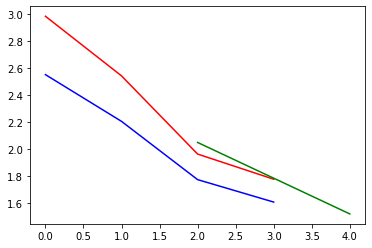

Restoring snapshot from epoch 2 with valid loss: 1.5217
TEST stats: acc: 58.33%, loss: 1.5111
TRAIN stats: acc: 66.77%, loss: 1.1954


In [4]:
trainer = None

try:
    trainer = CelebrityTrainer()
    trainer.train()

    confusion_matrix = trainer.confusion_matrix
    classes = trainer.classes
finally:
    if trainer:
        del trainer

* **What is the impact of batch size on accuracy?**

In [ ]:
mb_sizes = [8, 16, 32, 64, 96]
accs = []

for mb_size in mb_sizes:
    print(f'MB_SIZE: {mb_size}')
    acc, _ = CelebrityTrainer(mb_size=mb_size, stat_period=10000).train(plot_loss=False)
    accs.append(acc)
    
for mb_size, acc in zip(mb_sizes, accs):
    print(f'\nAcc for mb_size={mb_size} is {(acc * 100):.2f}%.')
    
plt.scatter(mb_sizes, accs)

MB_SIZE: 8
EPOCH 1
VALID stats: acc: 38.57%, loss: 2.1457
EPOCH 2
VALID stats: acc: 52.25%, loss: 1.6788
EPOCH 3
VALID stats: acc: 60.79%, loss: 1.3681
EPOCH 4
VALID stats: acc: 67.86%, loss: 1.1742
EPOCH 5
VALID stats: acc: 69.11%, loss: 1.0885
EPOCH 6


* **What is the impact of batch normalization on accuracy and learning speed?**

In [ ]:
CelebrityTrainer(batch_norm=False).train()

* **What optimizer gives the best results?**

In [ ]:
adam_no_amsgrad = partial(optim.Adam, lr=DEFAULT_LR, weight_decay=DEFAULT_WEIGHT_DECAY, amsgrad=False)
CelebrityTrainer(optimizer_lambda=adam_amsgrad).train()

In [ ]:
sgd = partial(optim.SGD, lr=100 * DEFAULT_LR, weight_decay=DEFAULT_WEIGHT_DECAY)
CelebrityTrainer(optimizer_lambda=sgd).train()

In [ ]:
sgd_momentum = partial(optim.SGD, momentum=0.9, lr=100 * DEFAULT_LR, weight_decay=DEFAULT_WEIGHT_DECAY)
CelebrityTrainer(optimizer_lambda=sgd_momentum).train()

In [ ]:
adagrad = partial(optim.Adam, lr=DEFAULT_LR, weight_decay=DEFAULT_WEIGHT_DECAY)
CelebrityTrainer(optimizer_lambda=adagrad).train()

In [ ]:
rmsprop = partial(optim.Adam, lr=DEFAULT_LR, weight_decay=DEFAULT_WEIGHT_DECAY)
CelebrityTrainer(optimizer_lambda=rmsprop).train()

# Task 4 - results (1 point)

Prepare a confusion matrix of your network. Explain the values in it.

In [8]:
for i, cl in enumerate(classes):
    print(f'{i}: {cl}')

0: 0000204
1: 0000210
2: 0000439
3: 0000662
4: 0001774
5: 0004266
6: 0004770
7: 0004937
8: 0005527
9: 0006969
10: 0010075
11: 0010736
12: 0068338
13: 0177896
14: 0221043
15: 0221046
16: 0358316
17: 0424060
18: 0515116
19: 0519456
20: 0688132
21: 0829576
22: 0913488
23: 1015262
24: 1312575
25: 1374980
26: 1415323
27: 1433588


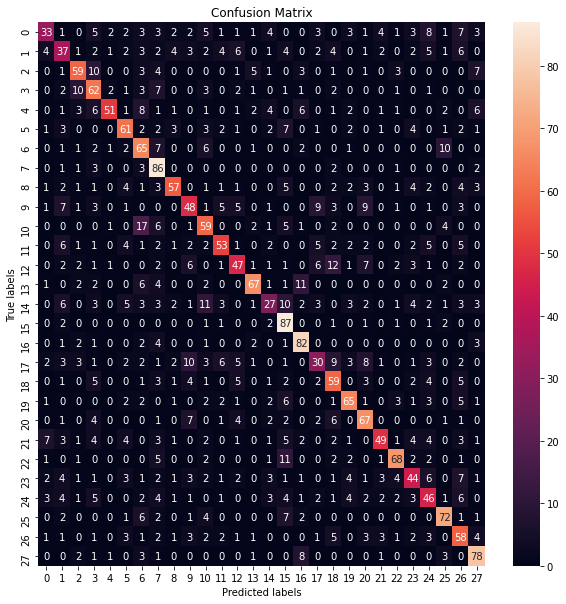

In [10]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(confusion_matrix)


The confusion matrix graphically represents comparison of our predictions and ground truth.
The larger the values on the diagonal, the better.

We expect, that large values outside of diagonal imply similarity of classes.
Below I present 3 of the confused classes. Although it's subjective, I believe it fits the hypothesis.

These two actors are somewhat similar and they usually wear similar haircuts.

| class 10 | class 6 |
|:---:|:---:|
| ![10](dnn2020-1/test/0010075/003.jpg) | ![6](dnn2020-1/test/0004770/004.jpg) |

These two actresses are almost always seen in blonde hair.

| class 12 | class 8 |
|:---:|:---:|
| ![12](dnn2020-1/test/0068338/004.jpg) | ![6](dnn2020-1/test/0515116/003.jpg) |

These two actresses are actually sisters.

| class 14 | class 15 |
|:---:|:---:|
| ![14](dnn2020-1/test/0221043/002.jpg) | ![15](dnn2020-1/test/0221046/003.jpg) |